In [21]:
# Approximate Label Matching (ALM; Ash et al., 2017) implementation in PyTorch.
# Read the paper at https://arxiv.org/pdf/1602.04889.pdf
import time
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

import cv2
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from keras.datasets import mnist , mnist_m
from keras.utils import np_utils


'''
DATA HANDLING
'''

def batch_generator(x, y, n_split):
    
    # create validation split
    kf = KFold(n_splits=n_split, random_state=0)
    
    for i, (_, split) in enumerate(kf.split(x)):
        print('\rBatch {}/{}'.format(i+1, n_split), end='')
        x_split, y_split = x[split], y[split]

        # create torch tensor variable from split
        x_split = Variable(torch.from_numpy(x_split))
        y_split = Variable(torch.from_numpy(y_split))
        
        # yield split
        yield x_split, y_split, split
    

def data_loader(dataset):

    # helper function to normalize images between -1 and 1
    def normalize_img(x):
        return -1 + ((x - np.min(x)) * (2)) / (np.max(x) - np.min(x))

    # load and process MNIST-M dataset
    if dataset == 'mnist_m':
        print('Loading {} data..'.format(dataset.upper()))
        
        # load mnist_m data
        mnistm = mnist_m.load_data()
        
        # load target variable from mnist
        (_, yt_train), (__, yt_test) = mnist.load_data()
        del _, __ 
        
        # create train / test split
        xt_train = mnistm[b'train']
        xt_test = mnistm[b'test']
        
        # preprocess (reshape, float32, normalize)
        xt_train = xt_train.transpose(0, 3, 1, 2).astype('float32') / 255
        xt_test = xt_test.transpose(0, 3, 1, 2).astype('float32') / 255
        
        # one hot encode target
        yt_train = np_utils.to_categorical(yt_train, 10)
        yt_test = np_utils.to_categorical(yt_test, 10)
 
        # return images
        return (xt_train[:10000], yt_train[:10000]), (xt_test[:5000], yt_test[:5000])

    # load and process USPS dataset
    if dataset == 'usps':
        print('Loading {} data..'.format(dataset.upper()))
        
        # load usps data
        with open('../data/usps/zip.train') as f:
            xt_train = f.readlines()
        with open('../data/usps/zip.test') as f:
            xt_test = f.readlines()
            
        # one hot encode target
        yt_train = np_utils.to_categorical(np.array([int(digit[0]) for digit in xt_train]), 10)
        yt_test = np_utils.to_categorical(np.array([int(digit[0]) for digit in xt_test]), 10)
        
        # preprocess (parse, reshape, float32)
        xt_train = np.array([np.delete(np.array(p.strip().split(' ')).astype('float32'), 0) for p in xt_train]).reshape(len(yt_train), 1, 16, 16)
        xt_test = np.array([np.delete(np.array(p.strip().split(' ')).astype('float32'), 0) for p in xt_test]).reshape(len(yt_test), 1, 16, 16)
        
        # zero-pad usps images to shape (1 x 28 x 28; compatible with mnist)
        xt_train = np.array([np.pad(img, ((0,0),(6,6),(6,6)), 'constant', constant_values=-1) for img in xt_train])
        xt_test = np.array([np.pad(img, ((0,0),(6,6),(6,6)), 'constant', constant_values=-1) for img in xt_test])

        # normalize image values between -1 and 1
        xt_train = np.array([normalize_img(img) for img in xt_train])
        xt_test = np.array([normalize_img(img) for img in xt_test])
        
        return (xt_train, yt_train), (xt_test, yt_test)

    # load and process MNIST dataset
    elif dataset == 'mnist':
        print('Loading {} data..'.format(dataset.upper()))
        
        # load mnist data
        (xs_train, ys_train), (xs_test, ys_test) = mnist.load_data()
        
        # preprocess (normalize, reshape, float32)
        xs_train = xs_train.reshape(xs_train.shape[0], 1, 28, 28).astype('float32') / 255
        xs_test = xs_test.reshape(xs_test.shape[0], 1, 28, 28).astype('float32') / 255
        xs_train = np.array([normalize_img(img) for img in xs_train])
        xs_test = np.array([normalize_img(img) for img in xs_test])
        
        # one hot encode target
        ys_train = np_utils.to_categorical(ys_train, 10)
        ys_test = np_utils.to_categorical(ys_test, 10)
        
        # return data
        if target_data == 'usps':
            
            # return same amount of MNIST samples as USPS images
            return (xs_train[:7291], ys_train[:7291]), (xs_test[:2007], ys_test[:2007])
        else:
            
            # concat MNIST images as channels to match number of MNIST-M channels
            xs_train = np.concatenate([xs_train, xs_train, xs_train], axis=1)
            xs_test = np.concatenate([xs_test, xs_test, xs_test], axis=1)
            return (xs_train[:10000], ys_train[:10000]), (xs_test[:5000], ys_test[:5000])


def plot():
    
    def norm_img(x):
        return ((x - np.min(x))) / (np.max(x) - np.min(x))
    
    rand_img = np.random.randint(0, 19, 1)[0]

    # take image from target domain and transform with generator 
    img = G(Variable(torch.from_numpy(Xt_train[:20]))).data.numpy()[rand_img]
    
    # plot generated, target, and source images
    subplot(1,3,1)
    plt.imshow(norm_img(img.transpose(1,2,0)))
    subplot(1,3,2)
    plt.imshow(norm_img(Xt_train[rand_img].transpose(1,2,0)))
    subplot(1,3,3)
    plt.imshow(norm_img(Xs_train[rand_img].transpose(1,2,0)))
    
    # print plot
    plt.show()



'''
MODELS
'''

# The generator model transforms target data as though it is sampled from source distribution
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, output_size, kernel_size=3, stride=1, padding=1)
        self.drop = nn.Dropout2d(.5)
        self.bn = nn.BatchNorm2d(64)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))                   
        x = self.drop(F.leaky_relu(self.bn(self.conv2(x))))
        x = self.drop(self.bn(self.conv2(x)))
        x = self.conv3(x)
        return F.tanh(x)

# The discriminator model tries to distinguish between source and target data
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.bn = nn.BatchNorm2d(20)
        self.drop = nn.Dropout2d(.25)
        self.fc1 = nn.Linear(320, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        x = F.leaky_relu(F.max_pool2d(self.drop(self.bn(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.leaky_relu(self.drop(self.fc1(x)))
        x = self.fc2(x)
        return F.sigmoid(x)
    
# The classifier model tries to guess the label of both source and target data
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 32, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(32, 48, kernel_size=5, stride=2)
        self.bn = nn.BatchNorm2d(48)
        self.fc1 = nn.Linear(432, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        self.drop = nn.Dropout2d(.25)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=1)
        x = F.max_pool2d(self.bn(self.conv2(x)), kernel_size=2, stride=1)
        x = x.view(-1, 432)
        x = F.leaky_relu(self.drop(self.fc1(x)))
        x = F.leaky_relu(self.drop(self.fc2(x)))
        return F.softmax(self.fc3(x))


# model parameters
print_interval = 50           # print example images every print_interval iterations
d_hidden_size = 100           # Discriminator complexity
c_hidden_size = 50            # Classifier complexity
d_learning_rate = 5e-5        # learning rate for discriminator
g_learning_rate = 5e-5        # learning rate for generator
c_learning_rate = 1e-3        # learning rate for classifier
l = 0.3                       # regularizer for adversarial loss
num_epochs = 10               # number of epochs to train models
clf_epochs = 4                # number of epochs to pretrain classifier
batch_size = 50               # size of image sample per epoch
source_data = 'mnist'         # mnist
target_data = 'mnist_m'       # mnist_m / usps
input_size = 3                # n_filters for target set; USPS has 1 greyscale filter
output_size = 3               # Transform to source set; MNIST has 1 greyscale filter
method = 'selective'          # default / selective / iterative


# load source domain dataset
(Xs_train, ys_train), (Xs_test, ys_test) = data_loader(source_data)

# load target domain dataset
(Xt_train, yt_train), (Xt_test, yt_test) = data_loader(target_data)

# set number of splits
n_split = int(round(Xs_train.shape[0] / batch_size))

# instantiate the models
G = Generator(input_size=input_size, output_size=output_size)
D = Discriminator(input_size=output_size, hidden_size=d_hidden_size)
C = Classifier(input_size=output_size, hidden_size=c_hidden_size)

# define loss functions
bce_crit = nn.BCELoss() # binary crossentropy
mse_crit = nn.MSELoss() # mean squared error: used to minimize equation 1.

# set the optimizers
d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=(0.9, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=(0.9, 0.999))
c_optimizer = optim.Adam(C.parameters(), lr=c_learning_rate, betas=(0.9, 0.999))



# Pre-train the classifier on source dataset
print('\n\nPre-training classifier model on {} dataset..'.format(source_data.upper()))
for epoch in range(clf_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, clf_epochs))
    
    # iterate over batches
    generator = batch_generator(Xs_train, ys_train, n_split)
    for batch in range(n_split):
        
        # reset gradients
        C.zero_grad()
        
        # get predictions from batch
        Xs, Ys, _ = next(generator)
        c_out = C(Xs)
        
        # forward and backward pass through classifier
        c_error = mse_crit(c_out, Ys.float())
        c_error.backward()
        c_optimizer.step()
    
    # evaluate on validation set
    Xstest = Variable(torch.from_numpy(Xs_test))
    Ystest = Variable(torch.from_numpy(ys_test))
    c_val_out = C(Xstest)
    c_val_error = mse_crit(c_val_out, Ystest.float())
    
    # print losses
    print(' - train_mse: {} - val_mse: {}'.format(format(c_error.data[0], '.4f'),
                                                format(c_val_error.data[0], '.4f')))

print('\nEvaluating classifier performance on {} and {} dataset..'.format(source_data.upper(), target_data.upper()))

# create approximate labels Ystar
Ystar = C(Variable(torch.from_numpy(Xt_train)))
t_classes = Ystar.max(1)[1].data.numpy().ravel()

# get subset of source test
Ys = C(Variable(torch.from_numpy(Xs_test[:1000])))
s_classes = Ys.max(1)[1].data.numpy().ravel()

# source data performance
upper_lim = accuracy_score(y_true=[np.argmax(i) for i in ys_test[:1000]], y_pred=s_classes)
print('{} accuracy: {}'.format(source_data.upper(), round(upper_lim, 3)))

# approximate label performance
lower_lim = accuracy_score(y_true=[np.argmax(i) for i in yt_train], y_pred=t_classes)
print('{} accuracy: {}'.format(target_data.upper(), round(lower_lim, 3)))

Loading MNIST data..
Loading MNIST_M data..


Pre-training classifier model on MNIST dataset..

Epoch 1/4
Batch 200/200 - train_mse: 0.0072 - val_mse: 0.0200

Epoch 2/4
Batch 200/200 - train_mse: 0.0041 - val_mse: 0.0101

Epoch 3/4
Batch 200/200 - train_mse: 0.0033 - val_mse: 0.0088

Epoch 4/4
Batch 200/200 - train_mse: 0.0023 - val_mse: 0.0078

Evaluating classifier performance on MNIST and MNIST_M dataset..
MNIST accuracy: 0.943
MNIST_M accuracy: 0.479




Training discriminator and generator..

Epoch 1/10
Batch 50/200 - 172s - d_mnist: 0.1714 - d_mnist_m: 0.2332 - g-d: 0.1840 - g-c: 0.0504 - mnist_m_val_acc: 0.4010


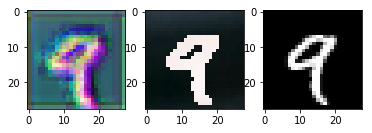

Batch 100/200 - 346s - d_mnist: 0.1607 - d_mnist_m: 0.2102 - g-d: 0.2075 - g-c: 0.0267 - mnist_m_val_acc: 0.4680


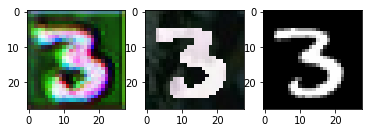

Batch 106/200
Updating approximate labels. Best label accuracy: 0.4820
Batch 110/200
Updating approximate labels. Best label accuracy: 0.4840
Batch 120/200
Updating approximate labels. Best label accuracy: 0.4900
Batch 131/200
Updating approximate labels. Best label accuracy: 0.4920
Batch 136/200
Updating approximate labels. Best label accuracy: 0.5110
Batch 150/200 - 522s - d_mnist: 0.1472 - d_mnist_m: 0.2201 - g-d: 0.2086 - g-c: 0.0398 - mnist_m_val_acc: 0.4850


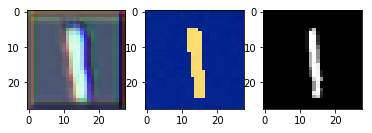

Batch 164/200
Updating approximate labels. Best label accuracy: 0.5200
Batch 176/200
Updating approximate labels. Best label accuracy: 0.5260
Batch 179/200
Updating approximate labels. Best label accuracy: 0.5280
Batch 192/200
Updating approximate labels. Best label accuracy: 0.5310
Batch 200/200 - 696s - d_mnist: 0.1455 - d_mnist_m: 0.1820 - g-d: 0.2542 - g-c: 0.0277 - mnist_m_val_acc: 0.5120


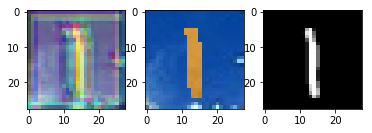


Epoch 2/10
Batch 9/200
Updating approximate labels. Best label accuracy: 0.5410
Batch 42/200
Updating approximate labels. Best label accuracy: 0.5530
Batch 50/200 - 173s - d_mnist: 0.1192 - d_mnist_m: 0.1747 - g-d: 0.2583 - g-c: 0.0333 - mnist_m_val_acc: 0.5330


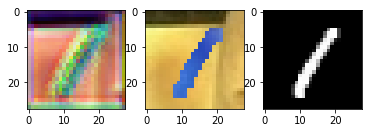

Batch 71/200
Updating approximate labels. Best label accuracy: 0.5590
Batch 93/200
Updating approximate labels. Best label accuracy: 0.5610
Batch 100/200 - 346s - d_mnist: 0.0914 - d_mnist_m: 0.1644 - g-d: 0.3223 - g-c: 0.0397 - mnist_m_val_acc: 0.5390


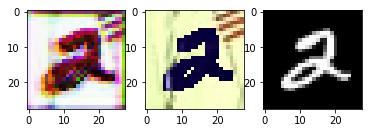

Batch 104/200
Updating approximate labels. Best label accuracy: 0.5640
Batch 109/200
Updating approximate labels. Best label accuracy: 0.5700
Batch 150/200 - 519s - d_mnist: 0.1039 - d_mnist_m: 0.1131 - g-d: 0.3629 - g-c: 0.0449 - mnist_m_val_acc: 0.5570


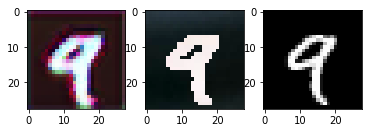

Batch 198/200
Updating approximate labels. Best label accuracy: 0.5710
Batch 200/200 - 692s - d_mnist: 0.1066 - d_mnist_m: 0.1250 - g-d: 0.4154 - g-c: 0.0450 - mnist_m_val_acc: 0.5730

Updating approximate labels. Best label accuracy: 0.5730


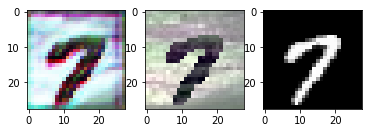


Epoch 3/10
Batch 6/200
Updating approximate labels. Best label accuracy: 0.5870
Batch 50/200 - 172s - d_mnist: 0.0915 - d_mnist_m: 0.0891 - g-d: 0.4491 - g-c: 0.0459 - mnist_m_val_acc: 0.5660


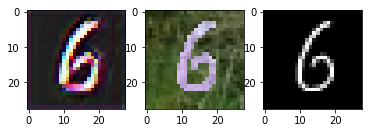

Batch 100/200 - 342s - d_mnist: 0.0669 - d_mnist_m: 0.1187 - g-d: 0.4427 - g-c: 0.0392 - mnist_m_val_acc: 0.5440


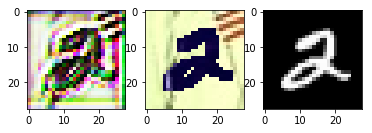

Batch 150/200 - 513s - d_mnist: 0.0784 - d_mnist_m: 0.0645 - g-d: 0.5531 - g-c: 0.0515 - mnist_m_val_acc: 0.5350


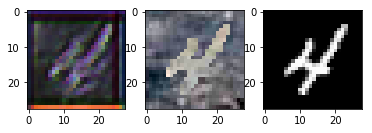

Batch 200/200 - 685s - d_mnist: 0.0945 - d_mnist_m: 0.0887 - g-d: 0.5127 - g-c: 0.0496 - mnist_m_val_acc: 0.5450


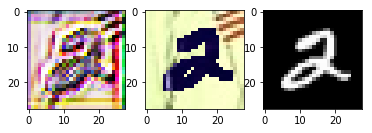


Epoch 4/10
Batch 50/200 - 173s - d_mnist: 0.0752 - d_mnist_m: 0.0901 - g-d: 0.5353 - g-c: 0.0449 - mnist_m_val_acc: 0.5660


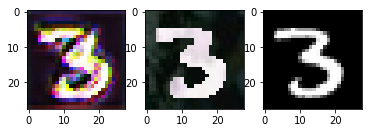

Batch 72/200
Updating approximate labels. Best label accuracy: 0.5930
Batch 100/200 - 345s - d_mnist: 0.0619 - d_mnist_m: 0.1182 - g-d: 0.4972 - g-c: 0.0508 - mnist_m_val_acc: 0.5720


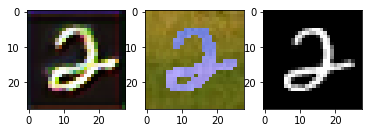

Batch 102/200
Updating approximate labels. Best label accuracy: 0.5960
Batch 106/200
Updating approximate labels. Best label accuracy: 0.5990
Batch 127/200
Updating approximate labels. Best label accuracy: 0.6010
Batch 129/200
Updating approximate labels. Best label accuracy: 0.6040
Batch 138/200
Updating approximate labels. Best label accuracy: 0.6090
Batch 144/200
Updating approximate labels. Best label accuracy: 0.6120
Batch 150/200 - 522s - d_mnist: 0.0602 - d_mnist_m: 0.1058 - g-d: 0.5282 - g-c: 0.0572 - mnist_m_val_acc: 0.6080


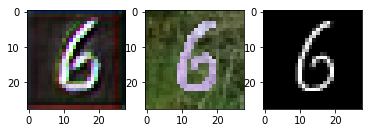

Batch 151/200
Updating approximate labels. Best label accuracy: 0.6230
Batch 173/200
Updating approximate labels. Best label accuracy: 0.6260
Batch 182/200
Updating approximate labels. Best label accuracy: 0.6270
Batch 183/200
Updating approximate labels. Best label accuracy: 0.6380
Batch 200/200 - 699s - d_mnist: 0.1288 - d_mnist_m: 0.1116 - g-d: 0.5817 - g-c: 0.0598 - mnist_m_val_acc: 0.6150


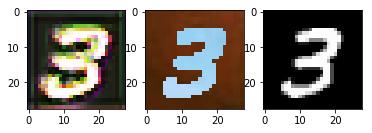


Epoch 5/10
Batch 7/200
Updating approximate labels. Best label accuracy: 0.6400
Batch 36/200
Updating approximate labels. Best label accuracy: 0.6450
Batch 37/200
Updating approximate labels. Best label accuracy: 0.6490
Batch 50/200 - 173s - d_mnist: 0.1235 - d_mnist_m: 0.1233 - g-d: 0.6026 - g-c: 0.0577 - mnist_m_val_acc: 0.6220


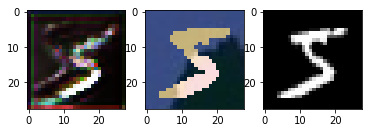

Batch 60/200
Updating approximate labels. Best label accuracy: 0.6500
Batch 62/200
Updating approximate labels. Best label accuracy: 0.6640
Batch 89/200
Updating approximate labels. Best label accuracy: 0.6740
Batch 100/200 - 351s - d_mnist: 0.0862 - d_mnist_m: 0.1512 - g-d: 0.5187 - g-c: 0.0528 - mnist_m_val_acc: 0.6770

Updating approximate labels. Best label accuracy: 0.6770


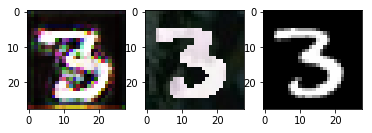

Batch 140/200
Updating approximate labels. Best label accuracy: 0.6810
Batch 150/200 - 526s - d_mnist: 0.0808 - d_mnist_m: 0.1675 - g-d: 0.4527 - g-c: 0.0710 - mnist_m_val_acc: 0.6520


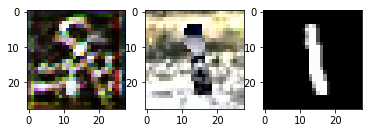

Batch 156/200
Updating approximate labels. Best label accuracy: 0.6880
Batch 175/200
Updating approximate labels. Best label accuracy: 0.6960
Batch 200/200 - 701s - d_mnist: 0.1485 - d_mnist_m: 0.1707 - g-d: 0.4465 - g-c: 0.0658 - mnist_m_val_acc: 0.6700


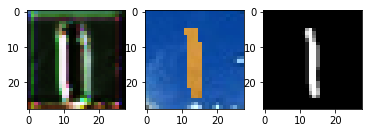


Epoch 6/10
Batch 27/200
Updating approximate labels. Best label accuracy: 0.7000
Batch 50/200 - 172s - d_mnist: 0.1182 - d_mnist_m: 0.1202 - g-d: 0.4947 - g-c: 0.0558 - mnist_m_val_acc: 0.6670


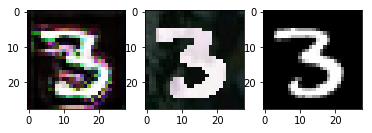

Batch 68/200
Updating approximate labels. Best label accuracy: 0.7040
Batch 92/200
Updating approximate labels. Best label accuracy: 0.7080
Batch 100/200 - 346s - d_mnist: 0.0868 - d_mnist_m: 0.1364 - g-d: 0.4581 - g-c: 0.0572 - mnist_m_val_acc: 0.6940


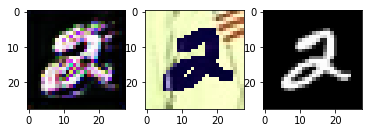

Batch 117/200
Updating approximate labels. Best label accuracy: 0.7100
Batch 148/200
Updating approximate labels. Best label accuracy: 0.7240
Batch 150/200 - 523s - d_mnist: 0.0968 - d_mnist_m: 0.2116 - g-d: 0.3706 - g-c: 0.0635 - mnist_m_val_acc: 0.6870


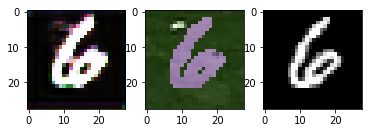

Batch 200/200 - 694s - d_mnist: 0.1469 - d_mnist_m: 0.1432 - g-d: 0.4243 - g-c: 0.0675 - mnist_m_val_acc: 0.6950


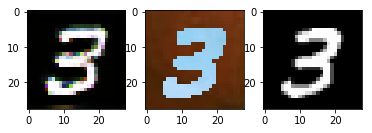


Epoch 7/10
Batch 50/200 - 174s - d_mnist: 0.1478 - d_mnist_m: 0.1068 - g-d: 0.4929 - g-c: 0.0629 - mnist_m_val_acc: 0.7140


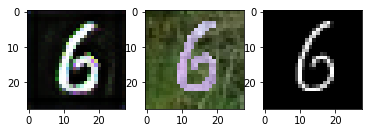

Batch 64/200
Updating approximate labels. Best label accuracy: 0.7250
Batch 100/200 - 347s - d_mnist: 0.1090 - d_mnist_m: 0.1459 - g-d: 0.4577 - g-c: 0.0551 - mnist_m_val_acc: 0.7200


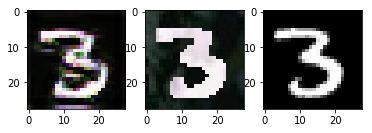

Batch 118/200
Updating approximate labels. Best label accuracy: 0.7260
Batch 150/200 - 522s - d_mnist: 0.1040 - d_mnist_m: 0.1984 - g-d: 0.3981 - g-c: 0.0616 - mnist_m_val_acc: 0.7040


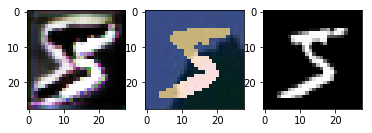

Batch 156/200
Updating approximate labels. Best label accuracy: 0.7280
Batch 161/200
Updating approximate labels. Best label accuracy: 0.7350
Batch 200/200 - 697s - d_mnist: 0.1353 - d_mnist_m: 0.1199 - g-d: 0.3482 - g-c: 0.0530 - mnist_m_val_acc: 0.7080


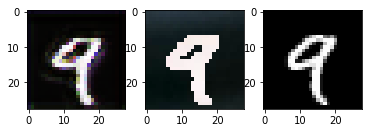


Epoch 8/10
Batch 50/200 - 173s - d_mnist: 0.1132 - d_mnist_m: 0.1308 - g-d: 0.4517 - g-c: 0.0520 - mnist_m_val_acc: 0.7080


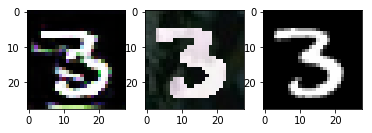

Batch 100/200 - 350s - d_mnist: 0.0940 - d_mnist_m: 0.1600 - g-d: 0.4455 - g-c: 0.0557 - mnist_m_val_acc: 0.7190


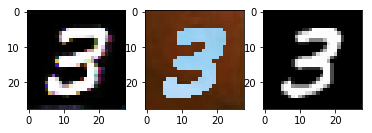

Batch 139/200
Updating approximate labels. Best label accuracy: 0.7360
Batch 150/200 - 525s - d_mnist: 0.1141 - d_mnist_m: 0.1963 - g-d: 0.4067 - g-c: 0.0660 - mnist_m_val_acc: 0.6970


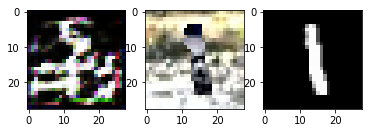

Batch 166/200
Updating approximate labels. Best label accuracy: 0.7450
Batch 200/200 - 701s - d_mnist: 0.1166 - d_mnist_m: 0.1432 - g-d: 0.3977 - g-c: 0.0619 - mnist_m_val_acc: 0.7170


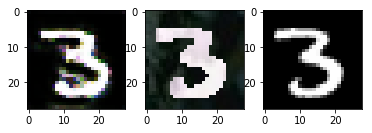


Epoch 9/10
Batch 50/200 - 174s - d_mnist: 0.1175 - d_mnist_m: 0.1110 - g-d: 0.5011 - g-c: 0.0458 - mnist_m_val_acc: 0.7220


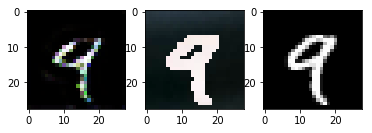

Batch 100/200 - 349s - d_mnist: 0.1294 - d_mnist_m: 0.1635 - g-d: 0.4243 - g-c: 0.0587 - mnist_m_val_acc: 0.7080


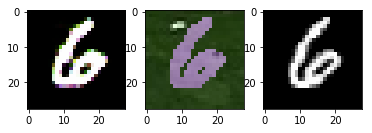

Batch 150/200 - 525s - d_mnist: 0.0874 - d_mnist_m: 0.1944 - g-d: 0.3734 - g-c: 0.0623 - mnist_m_val_acc: 0.7180


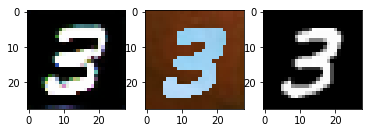

Batch 200/200 - 700s - d_mnist: 0.1150 - d_mnist_m: 0.1141 - g-d: 0.5095 - g-c: 0.0573 - mnist_m_val_acc: 0.7290


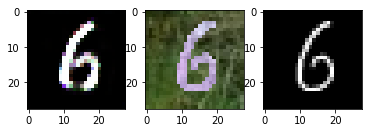


Epoch 10/10
Batch 50/200 - 173s - d_mnist: 0.1343 - d_mnist_m: 0.0973 - g-d: 0.4950 - g-c: 0.0509 - mnist_m_val_acc: 0.7180


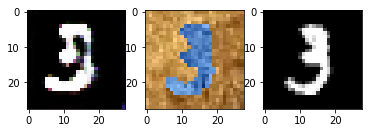

Batch 61/200
Updating approximate labels. Best label accuracy: 0.7530
Batch 100/200 - 349s - d_mnist: 0.0950 - d_mnist_m: 0.1672 - g-d: 0.4383 - g-c: 0.0503 - mnist_m_val_acc: 0.7110


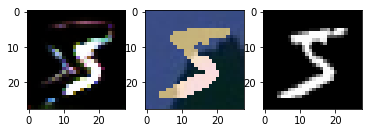

Batch 150/200 - 523s - d_mnist: 0.0855 - d_mnist_m: 0.2543 - g-d: 0.3521 - g-c: 0.0609 - mnist_m_val_acc: 0.7230


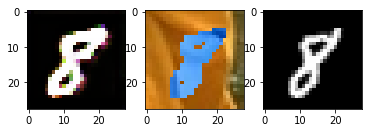

Batch 200/200 - 698s - d_mnist: 0.1148 - d_mnist_m: 0.1156 - g-d: 0.5190 - g-c: 0.0633 - mnist_m_val_acc: 0.7240


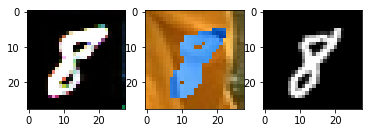

In [22]:
# obtain approximate labels for target set
y_appr = np_utils.to_categorical(t_classes, 10)
X_val = Variable(torch.from_numpy(Xt_test[:1000]))

# create lists for losses and accuracies
acc_vec = []
d_loss_vec = []
c_loss_vec = []
update_iter = []
best_acc = lower_lim

# train the approximate label matcher model
print('\n\nTraining discriminator and generator..')
for epoch in range(num_epochs):
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    start_time = time.time()
    
    # prepare source and target batch
    source_gen = batch_generator(Xs_train, ys_train, n_split)
    target_gen = batch_generator(Xt_train, yt_train, n_split)
    
    # iterate over batches
    for i, batch in enumerate(range(n_split)):
    
        # get batch of source, target data and discriminator target
        Xs, _, split_idx = next(source_gen)
        Xt, _, split_idx = next(target_gen)        
        y_ones = Variable(torch.ones((len(Xt), 1)))     # ones for source
        y_zeros = Variable(torch.zeros((len(Xt), 1)))   # zeros for target
        
        # failsafe for batch generator
        if len(split_idx) != batch_size:
            continue

        # get approx labels for batch
        y_approx = Variable(torch.from_numpy(y_appr[split_idx]))

        # 1) TRAIN THE DISCRIMINATOR
        D.zero_grad()

        # 1a) Train the discriminator on source images
        d_out = D(Xs)
        d_source_loss = bce_crit(d_out, y_ones) * l
        d_source_loss.backward(retain_variables=True)


        # 1b) Train the discriminator on target images
        d_out = D(G(Xt))
        d_target_loss = bce_crit(d_out, y_zeros) * l
        d_target_loss.backward(retain_variables=True)
        d_optimizer.step()

        # 2) TRAIN THE GENERATOR
        G.zero_grad()

        # 2a) Train the generator on discriminator response
        d_out = D(G(Xt))
        g_d_loss = bce_crit(d_out, y_ones) * l   # fool discriminator (ones for target)
        g_d_loss.backward(retain_variables=True)
        g_optimizer.step()

        # 2b) Train the generator on classifier response
        G.zero_grad()

        c_out = C(G(Xt))
        g_c_loss = mse_crit(c_out, y_approx.float()) * (1 - l)
        g_c_loss.backward(retain_variables=True)
        g_optimizer.step()


        # 3) Print losses and target validation accuracy
        Y_val = C(G(X_val))
        _, t_classes = Y_val.max(1)
        acc = accuracy_score(y_true=[np.argmax(i) for i in yt_test[:1000]], y_pred=t_classes.data.numpy().ravel())
        
        if (i+1) % print_interval == 0:
            print(' - {}s - d_{}: {} - d_{}: {} - g-d: {} - g-c: {} - {}_val_acc: {}\n'.format(
                        round(time.time() - start_time),
                        source_data, format(d_source_loss.data[0], '.4f'), 
                        target_data, format(d_target_loss.data[0], '.4f'), 
                        format(g_d_loss.data[0], '.4f'),
                        format(g_c_loss.data[0], '.4f'),
                        target_data, format(acc, '.4f')), end='')
        
        
        # save losses to vector
        acc_vec.append(float(format(acc, '.4f')))
        d_loss_vec.append(float(format(g_d_loss.data[0], '.4f')))
        c_loss_vec.append(float(format(g_c_loss.data[0], '.4f')))

        # iterative label matching method
        if method == 'selective':
            # remember best acc with labels
            new_best = np.max([np.max(acc_vec), lower_lim])
            if new_best > best_acc:
                print('\nUpdating approximate labels. Best label accuracy: {}'.format(format(new_best, '.4f')))

                # update approximate labels
                del Ystar
                Ystar = C(Variable(torch.from_numpy(Xt_train)))
                t_classes = Ystar.max(1)[1].data.numpy().ravel()
                y_appr = np_utils.to_categorical(t_classes, 10)

                # remember new best accuracy and save iteration of update
                best_acc = new_best
                update_iter.append(int((epoch*i)+i))
        
        # continuous label update method
        if method == 'iterative':
            del Ystar
            Ystar = C(Variable(torch.from_numpy(Xt_train)))
            t_classes = Ystar.max(1)[1].data.numpy().ravel()
            y_appr = np_utils.to_categorical(t_classes, 10)

        # plot example images
        if (i+1) % print_interval == 0:
            plot()

In [23]:
import pandas as pd
from math import factorial


def sg_filter(y, window_size=101, order=3, deriv=0, rate=1):
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    firstvals = y[0] - np.abs(y[1:half_window+1][::-1] - y[0])
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve(m[::-1], y, mode='valid')

def plot_loss(title, acc, dloss, closs, smoothen=False):
    if smoothen:
        acc = sg_filter(np.array(acc))
        dloss = sg_filter(np.array(dloss))
        closs = sg_filter(np.array(closs))
    fig, ax = plt.subplots()
    ax.plot(range(len(acc)), acc, label='t_val_acc')
    ax.plot(range(len(acc)), dloss, label='d_loss')
    ax.plot(range(len(acc)), closs, label='c_loss')
    legend = ax.legend(loc='center right')
    plt.title(title)

df = pd.DataFrame({'acc':acc_vec, 'd_loss':d_loss_vec, 'c_loss':c_loss_vec})
df.to_csv('{}_{}_{}_{}.csv'.format(target_data, method, format(lower_lim, '.4f'), 'di1909'))

In [26]:
df = pd.read_csv('/home/fernando_bartolome3/mnist_m_selective_0.4793_di1909.csv')
default = pd.read_csv('/home/fernando_bartolome3/mnistm_default_0.5048')
iterative = pd.read_csv('/home/fernando_bartolome3/mnist_m_selective_0.4594.csv')
cont = pd.read_csv('/home/fernando_bartolome3/mnist_m_cont_0.4644.csv')

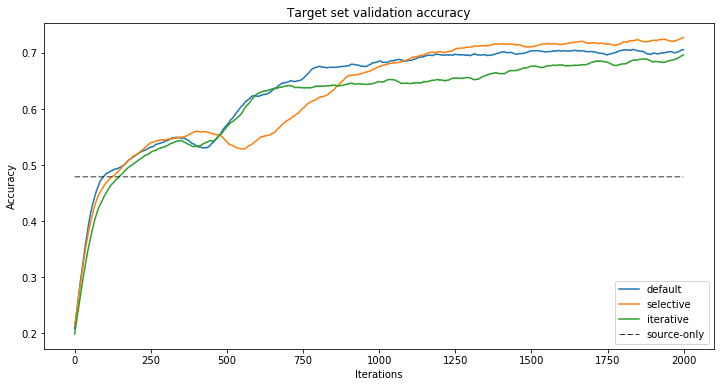

In [57]:
fig, ax = plt.subplots(1,1,figsize=(12, 6))
ax.plot(range(len(default.acc)), sg_filter(np.array(default.acc)), label='default')
ax.plot(range(len(default.acc)), sg_filter(np.array(df.acc)), label='selective')
ax.plot(range(len(default.acc)), sg_filter(np.array(cont.acc)), label='iterative')
ax.plot(range(len(default.acc)), np.repeat(0.479, len(default.acc)), 'k--',label='source-only', linewidth=0.8)
legend = ax.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Target set validation accuracy')

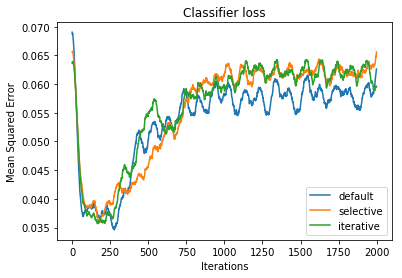

In [60]:
fig, ax = plt.subplots()
ax.plot(range(len(default.acc)), sg_filter(np.array(default.c_loss)), label='default')
ax.plot(range(len(default.acc)), sg_filter(np.array(df.c_loss)), label='selective')
ax.plot(range(len(default.acc)), sg_filter(np.array(cont.c_loss)), label='iterative')
legend = ax.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Classifier loss')

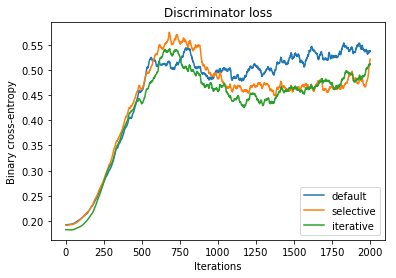

In [31]:
fig, ax = plt.subplots()
ax.plot(range(len(default.acc)), sg_filter(np.array(default.d_loss)), label='default')
ax.plot(range(len(default.acc)), sg_filter(np.array(df.d_loss)), label='selective')
ax.plot(range(len(default.acc)), sg_filter(np.array(cont.d_loss)), label='iterative')
legend = ax.legend(loc='lower right')
plt.xlabel('Iterations')
plt.ylabel('Binary cross-entropy')
plt.title('Discriminator loss')

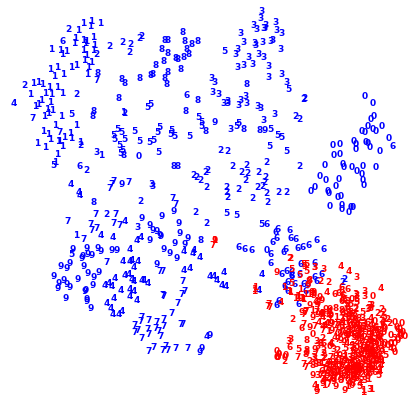

In [29]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# function to plot dataset embeddings
def plot_embedding(x, y, d, title=None):
    plt.figure(figsize=(7, 7), frameon=False)
    plt.subplot(111)
    for i in range(x.shape[0]):
        plt.text(x[i, 0], x[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    if title is not None:
        plt.title(title)

def norm_img(x):
    return ((x - np.min(x))) / (np.max(x) - np.min(x))

xt_train = np.mean(Xt_train, axis=1).reshape((Xt_train.shape[0], -1))[:500]
xs_train = np.mean(Xs_train, axis=1).reshape((Xs_train.shape[0], -1))[:500]
    
tsne = TSNE(n_components=2, init='pca', random_state=0)
xs_tsne = norm_img(tsne.fit_transform(xs_train))
xt_tsne = norm_img(tsne.fit_transform(xt_train))

x_tsne = np.concatenate((xs_tsne, xt_tsne)) 
class_lab = np.concatenate((ys_train[:500].argmax(1), yt_train[:500].argmax(1)))
domain_lab = np.concatenate((np.repeat(0, len(xs_tsne)), np.repeat(1, len(xt_tsne))))
    
plot_embedding(x_tsne, class_lab, domain_lab)

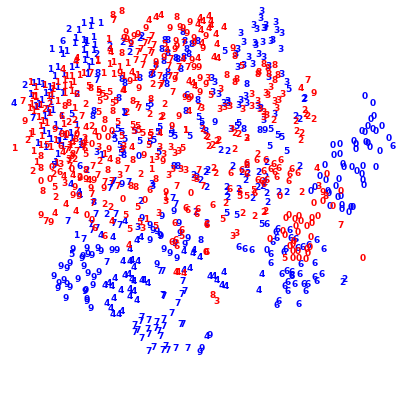

In [30]:
xt_train = G(Variable(torch.from_numpy(Xt_train[:500])))
xt_train = np.mean(xt_train.data.numpy(), axis=1).reshape((500, -1))
xs_train = np.mean(Xs_train, axis=1).reshape((Xs_train.shape[0], -1))[:500]

tsne = TSNE(n_components=2, init='pca', random_state=0)
xs_tsne = norm_img(tsne.fit_transform(xs_train))
xt_tsne = norm_img(tsne.fit_transform(xt_train))

x_tsne = np.concatenate((xs_tsne, xt_tsne)) 
class_lab = np.concatenate((ys_train[:500].argmax(1), yt_train[:500].argmax(1)))
domain_lab = np.concatenate((np.repeat(0, len(xs_tsne)), np.repeat(1, len(xt_tsne))))
    
plot_embedding(x_tsne, class_lab, domain_lab)